# Martingale strategy simulation


In this notebbok we simulate a martingale betting schema on an European roulette. The player always bet on black, and follow this rules:
1. the first bet is 1$;
1. if the player wins the bet, it wins 2$, stops the bet sequence and get a reward of 1$;
1. otherwise, it doubles the stack and bet 2$ on black again;
1. if it wins, the betting sequence stops, with a net profit of 1$;
1. if it loses, it doubles the stack again, and so on;
1. if the player cannot double the stack beacus it has no enoguh money, the sequence stops, and the player restarts a new bet sequence from 1$;
1. the whole game stops if the player reaches a target capital, fixed at the start of the game, or loses all the money.

We will use pandas and seaborn to analyze the results and plot some graphs.

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.patches as mpatches
import seaborn as sns
from martingale_strategy import *

In [2]:
random.seed(42)
simulation = run_simulation(PLAYERS, 2 * STARTUP_CAPITAL)

In [3]:
max_len_history = max([len(player['history']) for player in simulation])
for player in simulation:
    last_capital = player['history'][-1]['capital']
    player['history'] += \
        [{'capital': last_capital, 'sequence': -1, 'bet': -1}] * (max_len_history - len(player['history'])) # last record

In [4]:
temp_df = pd.DataFrame(simulation)
# Data frame containing full history for each simulation
history = temp_df['history'].explode()
history_df = pd.DataFrame(history.to_list(), index=history.index)
history_df.index.name = 'player'
history_df.reset_index(inplace=True)
history_df['time'] = history_df.groupby('player').cumcount()
history_df.set_index(['player', 'time'], inplace=True)
history_df

capital  sequence  bet
player time                         
0      0         1000         0    0
       1          999         1    1
       2         1001         1    2
       3         1002         2    3
       4         1003         3    4
...               ...       ...  ...
999    14062        0        -1   -1
       14063        0        -1   -1
       14064        0        -1   -1
       14065        0        -1   -1
       14066        0        -1   -1

[14067000 rows x 3 columns]

In [5]:
# Data frame containing only simulation info
simulation_df = temp_df.drop(columns=['history'])
simulation_df = simulation_df.set_index(['player'])
simulation_df

,win,final_capital
player,,
0,False,0
1,False,0
2,True,2000
3,False,0
4,False,0
...,...,...
995,False,0
996,False,0
997,False,0


In [6]:
outcome_counts = simulation_df['win'].value_counts()
outcome_counts

False    660
True     340
Name: win, dtype: int64

##  A typical pattern

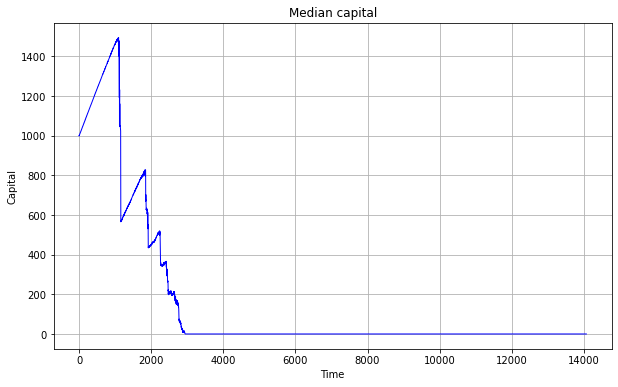

In [8]:
median_capital = history_df.drop(columns=['sequence', 'bet']).groupby('time').median()

def plot_capital_time_series(capital_time_series, title = ''):
    # Print a line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=capital_time_series, 
        x=capital_time_series.index, y='capital',
        lw=1, color='blue'
    )

    # Customize the plot
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.grid(True)
    return plt

median_plot = plot_capital_time_series(median_capital, title='Median capital')
median_plot.show()

In [9]:
def distance_from_median(x):
    '''
    Receive in input the time series of a simulation and calculted the distance from the time series of medians
    '''
    distance = abs(x[['capital']] - median_capital)
    return distance.sum()

simulation_df['dist_from_median'] = \
    simulation_df.index.to_series().apply(lambda x: distance_from_median(history_df.loc[x]))

# The "typical" player chosen as representative
typical_player = simulation_df[simulation_df['dist_from_median'] == simulation_df['dist_from_median'].min()]
typical_player

,win,final_capital,dist_from_median
player,,,
441,False,0,277296.5


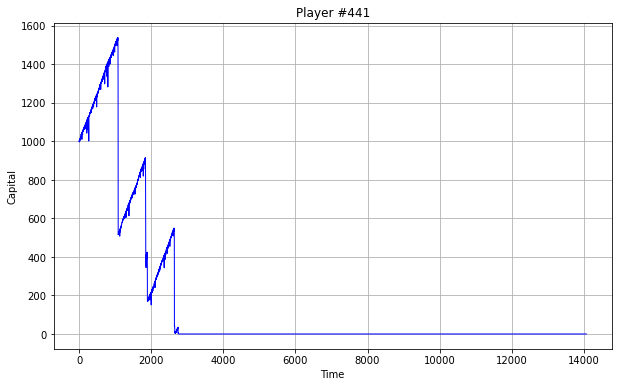

In [10]:
typical_player_index = typical_player.index[0]
typical_player_history = history_df.loc[typical_player_index]
typical_player_plot = plot_capital_time_series(
    typical_player_history, title='Player #{}'.format(typical_player_index)
)
typical_player_plot.show()

## Win and losses with different targets


In [16]:
simulations = []
for target_mutiplier in range (2, 11):
    target_mutiplier = target_mutiplier * 0.5
    simulation = run_simulation(PLAYERS, target_mutiplier * STARTUP_CAPITAL)
    simulation = pd.DataFrame(simulation).drop(columns=['history'])
    simulation['multiplier'] = target_mutiplier
    simulations += [simulation]
simulations_df = pd.concat(simulations)

In [17]:
win_loss_count = \
    simulations_df.drop(columns=['player', 'final_capital']).groupby('multiplier').value_counts()
win_loss_count = win_loss_count.unstack('win')
win_loss_count.columns = ['Loss', 'Win']
win_loss_count

,Loss,Win
multiplier,,
1.0,1,999
1.5,456,544
2.0,665,335
2.5,745,255
3.0,828,172
3.5,839,161
4.0,882,118
4.5,892,108
5.0,915,85


## Resources

* https://gitlab.com/luke-anto-medium-publishing/martingale/-/blob/main/martingale.ipynb?ref_type=heads